# Week 9: Clustering of Masaeli et al.

We're going to reimplement an SVM model from a [Di Carlo lab's study of the mechanical properties of cells](https://www.nature.com/articles/srep37863). With this, we'll then explore some of its properties.

In [21]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import kstest, ttest_ind, ks_2samp, zscore


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.svm import SVC # "Support vector classifier

mat = pd.read_csv('WBC.csv')
mat.drop('Unnamed: 0', axis=1, inplace=True)

data = pd.DataFrame(mat)

cell_identity = np.arange(0,10108)
columns = data.loc[:,['V1','V2']]
samples = data.loc[:,['Sample']]

#### (1) Choose any two variables and plot them against cell identity (in color). Do you see clear separation of these classes? What does this tell you about whether or not you can classify the cells of differing type?

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'Sample'],
      dtype='object')


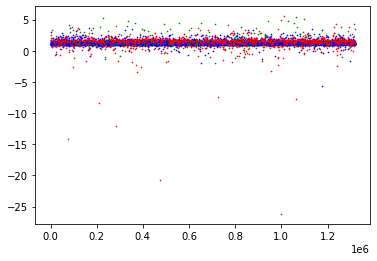

In [9]:
data = pd.DataFrame(mat)


cell_identity = np.arange(0,10108)
columns = data.loc[:,['V1','V2']]
samples = data.loc[:,['Sample']]

for i in range(len(cell_identity)):
    if samples.iloc[i,0]== samples.iloc[1,0]:
        color = 'b'
        labeli = 'WBC'
    if samples.iloc[i,0]== samples.iloc[10000,0]:
        color = 'r'
        labeli = 'MCF7'
    if samples.iloc[i,0]== samples.iloc[8760,0]:
        color = 'g'
        labeli = 'HL60'
    plt.scatter(columns.iloc[i,0],columns.iloc[i,1],s=.4,c=color,label = labeli)
    plt.xlabel = 'V1'
    plt.ylabel = 'V2'
    plt.legend = ()

In [ ]:
samples.iloc[10000,0]
x = data.loc[:,['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19']]

#### (2) Use principal components analysis to visualize the variation in each variable. Plot the first two principal components against the cell type. Do you see better separation in this case? What does this tell you about your ability to distinguish the cell types?

(10108, 19)


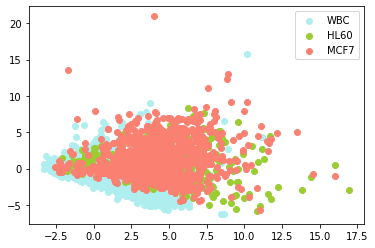

In [22]:
from sklearn.preprocessing import scale 
x = data.loc[:,['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19']]
x = scale(x)
print(x.shape)
pca = PCA(n_components=2)
principalcomponents = pca.fit_transform(x)

plt.scatter(principalcomponents[0:8629, 0], principalcomponents[0:8629, 1],c='paleturquoise',label = 'WBC')
plt.scatter(principalcomponents[8629:8951, 0],principalcomponents[8629:8951, 1],c='yellowgreen',label = 'HL60')
plt.scatter(principalcomponents[8951:, 0], principalcomponents[8951:, 1],c='salmon',label ='MCF7')
plt.legend()

#### (3) How does partial least squares regression fare in discriminating cancer and non-cancer cells (make cancer=1 and non-cancer=0; this is called PLS-DA)? How does this relate to the results in the previous questions?

In [9]:
from sklearn.cross_decomposition import PLSRegression

#columns = np.append(columns,np.zeros(len(columns)))
y = np.zeros(len(columns))
normofx = zscore(x)

for i in range(len(cell_identity)):
    if samples.iloc[i,0]== samples.iloc[1,0]:
        y[i] = 0
        labeli = 'WBC'
    if samples.iloc[i,0]== samples.iloc[10000,0]:
        y[i] = 1
        labeli = 'MCF7'
    if samples.iloc[i,0]== samples.iloc[8760,0]:
        y[i] = 1
        labeli = 'HL60'

    


plsr = PLSRegression(n_components=2)
plsr.fit(normofx,y)

xscores = plsr.x_scores_
yscores = plsr.y_scores_
xloadings = plsr.x_loadings_
yloadings = plsr.y_loadings_

In [ ]:
plt.scatter(xscores[0:8629, 0], xscores[0:8629, 1],c='paleturquoise',label = 'WBC')
plt.scatter(xscores[8629:8951, 0], xscores[8629:8951, 1],c='yellowgreen',label = 'HL60')
plt.scatter(xscores[8951:, 0], xscores[8951:, 1],c='salmon',label ='MCF7')
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#HL60 print(samples.iloc[8629:8951,0])

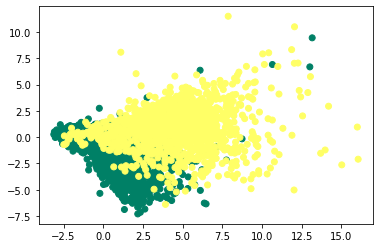

In [7]:
plt.scatter(xscores[:, 0], xscores[:, 1],c=y,cmap = 'summer')


#We can see here that we get similar results for PCA and PLSR! It does
#look like PLSR did a little bit of a better job of separating the 
#cancer vs. non cancer cell groups. 

#### (4) Setup a support vector machine classifier (with linear kernel) to distinguish cancer and non-cancer.

In [32]:
k = 40
kf = KFold(n_splits=k, random_state=None,shuffle =True)
acc_score = []
pred_y = np.zeros(len(x))

for train_index , test_index in kf.split(x,y):
    x_train , x_test = x[train_index,:],x[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    x_train = scale(x_train)
    x_test = scale(x_test)
    modelcv = SVC(kernel='linear')
    modelcv.fit(x_train,y_train)
    pred_y[test_index] = modelcv.predict(x_test)
    acc = accuracy_score(pred_y[test_index],y_test)
    acc_score.append(acc)
    
avg_acc_score = sum(acc_score)/k

print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.9683794466403162, 0.9683794466403162, 0.9683794466403162, 0.9841897233201581, 0.9683794466403162, 0.9802371541501976, 0.9802371541501976, 0.9604743083003953, 0.9802371541501976, 0.9644268774703557, 0.9644268774703557, 0.9723320158102767, 0.9604743083003953, 0.9604743083003953, 0.9881422924901185, 0.9723320158102767, 0.9565217391304348, 0.9723320158102767, 0.9762845849802372, 0.9683794466403162, 0.9486166007905138, 0.9525691699604744, 0.9723320158102767, 0.9723320158102767, 0.9762845849802372, 0.9802371541501976, 0.9762845849802372, 0.9486166007905138, 0.9603174603174603, 0.9682539682539683, 0.9761904761904762, 0.9761904761904762, 0.9801587301587301, 0.9642857142857143, 0.9761904761904762, 0.9722222222222222, 0.9880952380952381, 0.9761904761904762, 0.9682539682539683, 0.9722222222222222]
Avg accuracy : 0.9705215979672502


#### (5) Choose and justify your selection of a different kernel to use in SVM classification. (Hint: It should be a kernel with varying complexity, such as polynomial or RBF.)

In [23]:
from sklearn.utils import shuffle
k = 40
kf = KFold(n_splits=k, random_state=None,shuffle = True)
acc_score = []
pred_y = np.zeros(len(x))

score = []
for train_index , test_index in kf.split(x):
    x_train , x_test = x[train_index,:],x[test_index,:]
    y_train , y_test = y[train_index], y[test_index]
    x_train = scale(x_train)
    x_test = scale(x_test)
    modelcvrbf = SVC(kernel='rbf')
    modelcvrbf.fit(x_train,y_train)
    pred_y = modelcvrbf.predict(x_test)
    acc = accuracy_score(pred_y,y_test)
    acc_score.append(acc)
    
avg_acc_score = sum(acc_score)/k

print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

#As I am getting a higher accuracy for RBF than I am for the polynomial
#kernel method, I will proceed with this method. 

accuracy of each fold - [0.9604743083003953, 0.9762845849802372, 0.9565217391304348, 0.9762845849802372, 0.9841897233201581, 0.9644268774703557, 0.9881422924901185, 0.9762845849802372, 0.9762845849802372, 0.9683794466403162, 0.9762845849802372, 0.9723320158102767, 0.9762845849802372, 0.9683794466403162, 0.9604743083003953, 0.9802371541501976, 0.9881422924901185, 0.9723320158102767, 0.9802371541501976, 0.9762845849802372, 0.9683794466403162, 0.9762845849802372, 0.9762845849802372, 0.9604743083003953, 0.9486166007905138, 0.9723320158102767, 0.9762845849802372, 0.9723320158102767, 0.9841269841269841, 0.9880952380952381, 0.9603174603174603, 0.9841269841269841, 0.9801587301587301, 0.9484126984126984, 0.9801587301587301, 0.9642857142857143, 0.9523809523809523, 0.9880952380952381, 0.9880952380952381, 0.9603174603174603]
Avg accuracy : 0.9726955110107285


In [26]:
k = 40
kf = KFold(n_splits=k, random_state=None,shuffle=True)
acc_score = []
pred_y = np.zeros(len(x))

for train_index , test_index in kf.split(x):
    x_train , x_test = x[train_index,:],x[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    x_train = scale(x_train)
    x_test = scale(x_test)
    modelcv = SVC(kernel='poly')
    modelcv.fit(x_train,y_train)
    pred_y[test_index] = modelcv.predict(x_test)
    acc = accuracy_score(pred_y[test_index],y_test)
    acc_score.append(acc)
    
avg_acc_score = sum(acc_score)/k

print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.9683794466403162, 0.9644268774703557, 0.9644268774703557, 0.9802371541501976, 0.9604743083003953, 0.9486166007905138, 0.9802371541501976, 0.9723320158102767, 0.9644268774703557, 0.9604743083003953, 0.9644268774703557, 0.9486166007905138, 0.9841897233201581, 0.9683794466403162, 0.9762845849802372, 0.9723320158102767, 0.9723320158102767, 0.9762845849802372, 0.9644268774703557, 0.9802371541501976, 0.9723320158102767, 0.9683794466403162, 0.9525691699604744, 0.9486166007905138, 0.9644268774703557, 0.9802371541501976, 0.9486166007905138, 0.9565217391304348, 0.9722222222222222, 0.9801587301587301, 0.9603174603174603, 0.9880952380952381, 0.9722222222222222, 0.9523809523809523, 0.9642857142857143, 0.9642857142857143, 0.9801587301587301, 0.9642857142857143, 0.9682539682539683, 0.9841269841269841]
Avg accuracy : 0.9678508689378253


#### (6) Vary the complexity of your kernel and evaluate the ability of it to descriminate data both directly and on cross-validation.

How does the answer of which classification strategy vary based on whether you are performing cross-validation?

In [34]:
j = 0
cvalue = np.zeros(10)

k = 40
kf = KFold(n_splits=k, random_state=None,shuffle = True)

directpred_y = np.zeros(len(x))

directacc_score = []

avgcv_acc_score = np.zeros(10)
avgdirect_acc_score = np.zeros(10)

for i in range(10):
    j = j*10+1
    print(j)
    cvalue[i] = j
    acc_score = []
    pred_y = np.zeros(len(x))
    
    #for no cross validation 
    modeldirect = SVC(kernel='rbf',C=j)
    modeldirect.fit(x,y)
    directpred_y = modeldirect.predict(x)
    directacc = accuracy_score(directpred_y,y)
    directacc_score.append(directacc)
    
    #for cross validation
    for train_index , test_index in kf.split(x,y):
        x_train , x_test = x[train_index,:],x[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]
        x_train = scale(x_train)
        x_test = scale(x_test)
        modelcv = SVC(kernel='rbf',C=j)
        modelcv.fit(x_train,y_train)
        pred_y = modelcv.predict(x_test)
        acc = accuracy_score(pred_y,y_test)
        acc_score.append(acc)
    
    avgcv_acc_score[i] = sum(acc_score)/k
    
overallaccuracy_withcv = sum(avgcv_acc_score)/len(avgcv_acc_score)
overallaccuracy_nocv = sum(directacc_score)/len(directacc_score)

print('Avg accuracy w CV: {}'.format(avgcv_acc_score))
print('Avg accuracy wo CV: {}'.format(directacc_score))
print('Overall accuracy w CV: {}'.format(overallaccuracy_withcv))
print('Overall accuracy wo CV: {}'.format(overallaccuracy_nocv))

#We get better results without cross validation, which makes sense
#because without cross validation there is a larger sample size 
#being used in calculating the accuracy. 

1
11
111
1111
11111
111111
1111111
11111111
111111111
1111111111
Avg accuracy w CV: [0.97210341 0.97101449 0.96686547 0.9540855  0.94113182 0.93905397
 0.93935786 0.9409385  0.9396449  0.94252384]
Avg accuracy wo CV: [0.9818955282944203, 0.990403640680649, 0.9953502176493866, 0.9987138899881283, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Overall accuracy w CV: 0.950671975970889
Overall accuracy wo CV: 0.9966363276612583


[ 3.  6.  9. 12. 15. 18. 21. 24. 27. 30.]


Text(0, 0.5, 'Avg. SVM Accuracy wo CV')

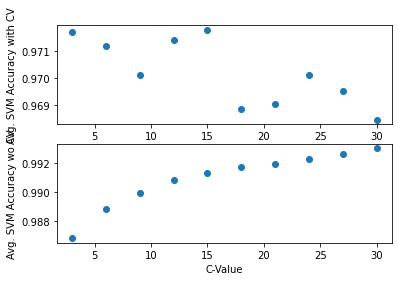

In [33]:
print(cvalue)
figure,axis = plt.subplots(2)
axis[0].scatter(cvalue,avgcv_acc_score)
axis[0].set_xlabel('C-Value')
axis[0].set_ylabel('Avg. SVM Accuracy with CV')

axis[1].scatter(cvalue,directacc_score)
axis[1].set_xlabel('C-Value')
axis[1].set_ylabel('Avg. SVM Accuracy wo CV')

In [ ]:
My average accuracy with changing C value in the cross validation case
seems to fluctuate considerably, which would make sense since 
cross validation is going to make the results a lot more sensitive
to overfitting. As for my case without cross validation, the trend 
of an increasing accuracy with increasing C value makes sense since
the model is more likely to overfit to the data. 


#### (7) Your experimental collaborator asks you to determine whether she can collect a fewer number of measurements (cells) and still obtain the same classification efficiency when building a new estimator. How might you determine this? Can she?

In [24]:
from sklearn.utils import resample 
import random

re_x = x
re_y = y

k = 40
kf = KFold(n_splits=k, random_state=None)
avg_acc_score = np.zeros(10)
samplesize = np.zeros(10)
for i in range(10): 
    #resample values
    re_x,re_y = resample(re_x,re_y,replace=False)#n_samples=np.random.randint(10
    samplesize[i] = re_x.size
    acc_score = []
    pred_y = np.zeros(len(re_x))
    
    for train_index , test_index in kf.split(x,y):
        x_train , x_test = re_x[train_index,:], re_x[test_index,:]
        y_train , y_test = re_y[train_index] , re_y[test_index]
        x_train = scale(x_train)
        x_test = scale(x_test)
        modelcv = SVC(kernel='rbf')
        modelcv.fit(x_train,y_train)
        pred_y[test_index] = modelcv.predict(x_test)
        acc = accuracy_score(pred_y[test_index],y_test)
        acc_score.append(acc)
    
    avg_acc_score[i] = sum(acc_score)/k
    

print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))
#There is a slight difference in accuracy as we change the sample size. 

accuracy of each fold - [0.9683794466403162, 0.9644268774703557, 0.9802371541501976, 0.9723320158102767, 0.9762845849802372, 0.9565217391304348, 0.9802371541501976, 0.9762845849802372, 0.9762845849802372, 0.9446640316205533, 0.9604743083003953, 0.9920948616600791, 0.9762845849802372, 0.9841897233201581, 0.9841897233201581, 0.9604743083003953, 0.9802371541501976, 0.9723320158102767, 0.9446640316205533, 0.9723320158102767, 0.9841897233201581, 0.9644268774703557, 0.9604743083003953, 0.9762845849802372, 0.9565217391304348, 0.9762845849802372, 0.9723320158102767, 0.9723320158102767, 0.9722222222222222, 0.9722222222222222, 0.9841269841269841, 0.9642857142857143, 0.9801587301587301, 0.9563492063492064, 0.9761904761904762, 0.9841269841269841, 0.9642857142857143, 0.9801587301587301, 0.9642857142857143, 0.9642857142857143]
Avg accuracy : [0.97190108 0.97348602 0.97110899 0.97269277 0.97229947 0.97091685
 0.97081334 0.97190892 0.97081334 0.97121173]


In [ ]:
plt.scatter(samplesize, avg_acc_score)

#### (8) What if you can change the numbers of individual cell types that you collect? Is the model you obtain sensitive to the number of cells in each group to the same extent? Try this with one cell population.

In [62]:
from sklearn.utils import resample 
import random
#'WBC'

k = 40
kf = KFold(n_splits=k, random_state=None)
avg_acc_score = np.zeros(10)

re_x = x 
re_y = y

for i in range(10): 
    #resample values
    re_x[8951:,:],re_y[8951:]= resample(re_x[8951:,:],re_y[8951:],replace=False)#n_samples=np.random.randint(10
    
    acc_score = []
    pred_y = np.zeros(len(re_x))
    
    for train_index , test_index in kf.split(x):
        x_train , x_test = re_x[train_index,:], re_x[test_index,:]
        y_train , y_test = re_y[train_index] , re_y[test_index]
        x_train = zscore(x_train)
        modelcv = SVC(kernel='rbf')
        modelcv.fit(x_train,y_train)
        pred_y[test_index] = modelcv.predict(x_test)
        acc = accuracy_score(pred_y[test_index],y_test)
        acc_score.append(acc)
    
    avg_acc_score[i] = sum(acc_score)/k

print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

#It appears that changing the number of individual cells collected
#makes your model less sensitive, and less accurate. We get results here
#around .96 as opposed to .97 in the prior case. 

accuracy of each fold - [0.9920948616600791, 0.9723320158102767, 0.9960474308300395, 0.9960474308300395, 0.9881422924901185, 0.9920948616600791, 0.9802371541501976, 1.0, 0.9881422924901185, 0.9881422924901185, 1.0, 1.0, 0.9762845849802372, 0.9920948616600791, 0.9841897233201581, 0.9960474308300395, 0.9723320158102767, 1.0, 0.9920948616600791, 0.9881422924901185, 0.9920948616600791, 0.9881422924901185, 0.9920948616600791, 0.9841897233201581, 0.9762845849802372, 0.9960474308300395, 0.9802371541501976, 0.9920948616600791, 0.9880952380952381, 0.9880952380952381, 0.9682539682539683, 0.9841269841269841, 0.9880952380952381, 0.9880952380952381, 0.6785714285714286, 0.8095238095238095, 0.8849206349206349, 0.9206349206349206, 0.9007936507936508, 0.9206349206349206]
Avg accuracy : [0.96758972 0.96758972 0.96808575 0.96798654 0.96808575 0.96838337
 0.96798654 0.96848257 0.96828416 0.96788734]


#### (9) You want to save your fit model, but want to reduce it so that you don't have to carry around all the data points. Which points could you remove and still have the same SVM model in the end?

In [ ]:
###If we'd like to save our SVM model to use later, we could just use the support 
###vectors. In SVM, the decision function is dependent solely on the three support vectors, 
###and thus the other points may be eliminate. 

#### (10) Your collaborator collects completely new data and brings it to you for classification. You take your chosen optimal model from (7) and classify each cell. Would you expect your model to perform better, identically, or worse than before? Why?

In [58]:
### I would expect my data to perform better than before. The model's
#accuracy was calculated via cross-validation which is known to 
#give an overestimation of the error. The error of our actual model is 
#based off of a larger sample size since none of it is removed to be used 
#as a validation data set, so it will be lower. 

(1157, 19)


#### (11) As a prior distribution, assume that, among patients coming in for testing, 99% are cancer-free in the end. Estimate how well your assay needs to perform for 90% of positive tests to in fact have cancer.

In [ ]:
p(cancer|+) = (p(+|cancer)*p(no cancer))/p(+)
we know: 
p(+|cancer) = accuracy 
p(cancer) = .01
p(no cancer) = .99
p(+)=p(+|cancer)*(p(cancer))+p(+|no cancer)*p(no cancer)
we can assume: 
specificity ~ .999  so that p(+|no cancer)=1-specificity=.001
so: 
p(+) = accuracy * .99 + .01 * .01

p(cancer|+) = ((accuracy)*.01)/((accuracy*0.01)+(0.001*0.99))

In [31]:
j = 90

accuracy = np.linspace(0.0,1,100)
answer = []
k = np.zeros(100)
for i in accuracy: 
    answer.append((i*0.01)/(i*0.01+(1-0.999)*0.99))
    
for i in range(len(answer)):
    if answer[i]>0.9:
        print(answer)